In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 12

In [30]:
def process_sequencing_summary(file_path):
    try:
        df = pd.read_csv(file_path, sep='\t')
        print(f"\nAvailable columns in {file_path}:")
        for col in df.columns:
            print(f"  - {col}")
        sequence_length_cols = [col for col in df.columns if 'sequence_length' in col.lower()]

        if not sequence_length_cols:
            raise ValueError(f"Could not find sequence length column in {file_path}")
        sequence_length_col = sequence_length_cols[0]
        print(f"\nUsing column '{sequence_length_col}' for sequence length")
        time_cols = [col for col in df.columns if 'time' in col.lower()]
        if not time_cols:
            raise ValueError(f"Could not find time column in {file_path}")
        start_time_col = next((col for col in time_cols if 'start' in col.lower()), time_cols[0])
        print(f"Using column '{start_time_col}' for start time")
        print(df[start_time_col].head())
        if pd.api.types.is_numeric_dtype(df[start_time_col]):
            df['hours'] = df[start_time_col] / 3600
        else:
            df['start_time'] = pd.to_datetime(df[start_time_col])
            start_time = df['start_time'].min()
            df['hours'] = (df['start_time'] - start_time).dt.total_seconds() / 3600
        df = df.sort_values('hours')
        df['cumulative_gigabases'] = df[sequence_length_col].cumsum() / 1e9

        return df[['hours', 'cumulative_gigabases']]

    except Exception as e:
        print(f"\nError processing file {file_path}:")
        print(f"Error details: {str(e)}")
        sys.exit(1)


def plot_readOutput (input_files, output_file):
    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(5, 4))
    colors = ['tab:blue', 'tab:orange']
    labels = ['negative control', '500uM positive control']
    min_x_limit = float('inf')
    for i, (file_path, color) in enumerate(zip(input_files, colors)):
        data = process_sequencing_summary(file_path)
        max_hours = data['hours'].max()
        if max_hours < min_x_limit:
            min_x_limit = max_hours
        ax.plot(data['hours'], data['cumulative_gigabases'],
                label=labels[i], color=color, linewidth=2)
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Cumulative output (Gb)')
    ax.set_title('Cumulative sequencing output over time', fontsize=14, pad=20)
    ax.set_xlim(0, 20)
    ax.set_ylim(0, None)
    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()
    plt.close()

In [12]:
neg = '../data/sequencing_summary/0uM_220331_sequencing_summary.txt'
pos = '../data/sequencing_summary/500uM_220331_sequencing_summary.txt'


Available columns in ../data/sequencing_summary/0uM_220331_sequencing_summary.txt:
  - filename
  - read_id
  - run_id
  - batch_id
  - channel
  - mux
  - start_time
  - duration
  - num_events
  - passes_filtering
  - template_start
  - num_events_template
  - template_duration
  - sequence_length_template
  - mean_qscore_template
  - strand_score_template
  - median_template
  - mad_template
  - scaling_median_template
  - scaling_mad_template

Using column 'sequence_length_template' for sequence length
Using column 'start_time' for start time
0    82345.71300
1    82173.40225
2    81977.16025
3    82351.45525
4    83432.46400
Name: start_time, dtype: float64

Available columns in ../data/sequencing_summary/500uM_220331_sequencing_summary.txt:
  - filename
  - read_id
  - run_id
  - batch_id
  - channel
  - mux
  - start_time
  - duration
  - num_events
  - passes_filtering
  - template_start
  - num_events_template
  - template_duration
  - sequence_length_template
  - mean_qscore

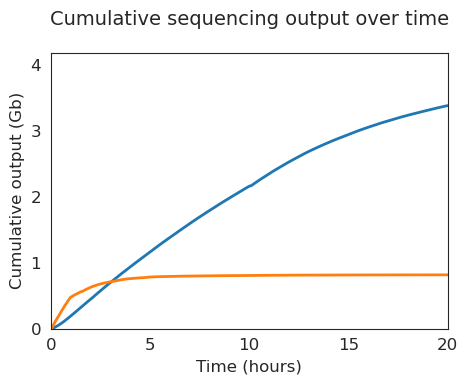

In [31]:
plot_readOutput([neg, pos], '../figures/7_pore_activity_summary.pdf')